In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import df_stored

In [18]:
# Assuming you want to use the dataframe from df_stored
#match = df_stored.match_df
match_df = pd.read_csv('../data/raw/Match.csv')
match_original_df = pd.read_csv('../data/raw/Match.csv')
match_df.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


In [19]:
match_df = match_df.drop(columns=['PSH', 'PSD', 'PSA'], errors='ignore')
match_df.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


In [20]:
# Display non-empty (non-null) values from the 'goal' column
non_empty_goals = match_df['goal'].dropna()
print(non_empty_goals.iloc[0])

<goal><value><comment>n</comment><stats><goals>1</goals><shoton>1</shoton></stats><event_incident_typefk>406</event_incident_typefk><elapsed>22</elapsed><player2>38807</player2><subtype>header</subtype><player1>37799</player1><sortorder>5</sortorder><team>10261</team><id>378998</id><n>295</n><type>goal</type><goal_type>n</goal_type></value><value><comment>n</comment><stats><goals>1</goals><shoton>1</shoton></stats><event_incident_typefk>393</event_incident_typefk><elapsed>24</elapsed><player2>24154</player2><subtype>shot</subtype><player1>24148</player1><sortorder>4</sortorder><team>10260</team><id>379019</id><n>298</n><type>goal</type><goal_type>n</goal_type></value></goal>


In [21]:
team_df = pd.read_csv('../data/raw/Team.csv')
team_df.head()

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB


In [22]:
# Merge team_df to match_df to get home and away team long names
match_df = match_df.merge(
    team_df[['team_api_id', 'team_long_name']],
    left_on='home_team_api_id',
    right_on='team_api_id',
    how='left'
).rename(columns={'team_long_name': 'home_team_long_name'}).drop('team_api_id', axis=1)

match_df = match_df.merge(
    team_df[['team_api_id', 'team_long_name']],
    left_on='away_team_api_id',
    right_on='team_api_id',
    how='left'
).rename(columns={'team_long_name': 'away_team_long_name'}).drop('team_api_id', axis=1)

# Show the first few rows with new columns
match_df[['home_team_api_id', 'home_team_long_name', 'away_team_api_id', 'away_team_long_name']].head()

,home_team_api_id,home_team_long_name,away_team_api_id,away_team_long_name
0,9987,KRC Genk,9993,Beerschot AC
1,10000,SV Zulte-Waregem,9994,Sporting Lokeren
2,9984,KSV Cercle Brugge,8635,RSC Anderlecht
3,9991,KAA Gent,9998,RAEC Mons
4,7947,FCV Dender EH,9985,Standard de Liège


In [23]:
print(match_df.columns[11])

home_player_X1


In [24]:
match_df.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA,home_team_long_name,away_team_long_name
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20,KRC Genk,Beerschot AC
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60,SV Zulte-Waregem,Sporting Lokeren
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75,KSV Cercle Brugge,RSC Anderlecht
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50,KAA Gent,RAEC Mons
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67,FCV Dender EH,Standard de Liège


In [25]:
match_df = match_df.drop(match_df.columns[11:55], axis=1)
match_df.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA,home_team_long_name,away_team_long_name
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20,KRC Genk,Beerschot AC
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60,SV Zulte-Waregem,Sporting Lokeren
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75,KSV Cercle Brugge,RSC Anderlecht
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50,KAA Gent,RAEC Mons
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67,FCV Dender EH,Standard de Liège


In [26]:
home_player_cols = [f'home_player_{i}' for i in range(1, 12)]
missing_counts = match_df[home_player_cols].isnull().sum()
missing_percent = match_df[home_player_cols].isnull().mean() * 100

stats_df = pd.DataFrame({
    'missing_count': missing_counts,
    'missing_percent': missing_percent
})

print(stats_df)

                missing_count  missing_percent
home_player_1            1224         4.711498
home_player_2            1315         5.061781
home_player_3            1281         4.930906
home_player_4            1323         5.092575
home_player_5            1316         5.065630
home_player_6            1325         5.100273
home_player_7            1227         4.723046
home_player_8            1309         5.038685
home_player_9            1273         4.900112
home_player_10           1436         5.527541
home_player_11           1555         5.985604


In [27]:
match_df.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA,home_team_long_name,away_team_long_name
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20,KRC Genk,Beerschot AC
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60,SV Zulte-Waregem,Sporting Lokeren
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75,KSV Cercle Brugge,RSC Anderlecht
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50,KAA Gent,RAEC Mons
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67,FCV Dender EH,Standard de Liège


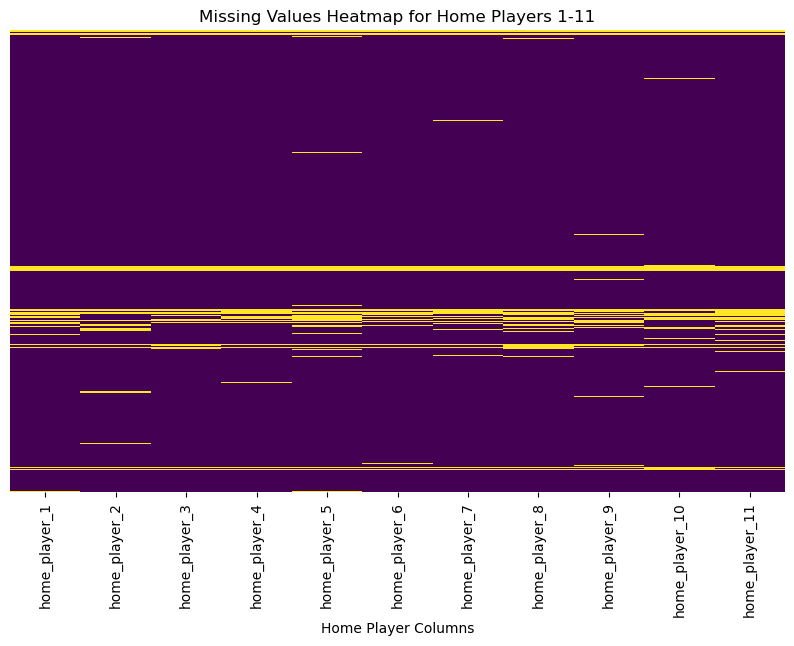

In [28]:
plt.figure(figsize=(10, 6))
sns.heatmap(match_df[home_player_cols].isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Values Heatmap for Home Players 1-11')
plt.xlabel('Home Player Columns')
plt.show()

In [29]:
player_df = pd.read_csv('../data/raw/Player.csv')
player_attributes_df = pd.read_csv('../data/raw/Player_Attributes.csv')

player_df.head(), player_attributes_df.head()

(   id  player_api_id         player_name  player_fifa_api_id  \
 0   1         505942  Aaron Appindangoye              218353   
 1   2         155782     Aaron Cresswell              189615   
 2   3         162549         Aaron Doran              186170   
 3   4          30572       Aaron Galindo              140161   
 4   5          23780        Aaron Hughes               17725   
 
               birthday  height  weight  
 0  1992-02-29 00:00:00  182.88     187  
 1  1989-12-15 00:00:00  170.18     146  
 2  1991-05-13 00:00:00  170.18     163  
 3  1982-05-08 00:00:00  182.88     198  
 4  1979-11-08 00:00:00  182.88     154  ,
    id  player_fifa_api_id  player_api_id                 date  overall_rating  \
 0   1              218353         505942  2016-02-18 00:00:00            67.0   
 1   2              218353         505942  2015-11-19 00:00:00            67.0   
 2   3              218353         505942  2015-09-21 00:00:00            62.0   
 3   4              218353 